In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# 正解の識別曲線
def f(x, y):
    return x*x * x - 4*x-y-1

In [4]:
def ker_ary(i, j):
    # j はX
    norm = np.linalg.norm(i - j , axis = 1)
    return np.exp(-gamma * norm * norm)

In [5]:
def w_f_ary(x):
    W = np.dot((alpha * T), ker_ary(x, X))
    return W

In [6]:
#カーネル関数
def ker(i, j):
    norm = np.linalg.norm(i - j)
    return np.exp(-gamma * norm * norm)

In [7]:
# N : データ数, d : 次元
N = 200
d = 2
X = np.random.rand(N, d) * 6 - 3

In [8]:
#正解ラベル
T = np.array([1 if f(x,y) > 0 else -1 for x, y in X])

In [9]:
W = np.zeros(2)
b = 0

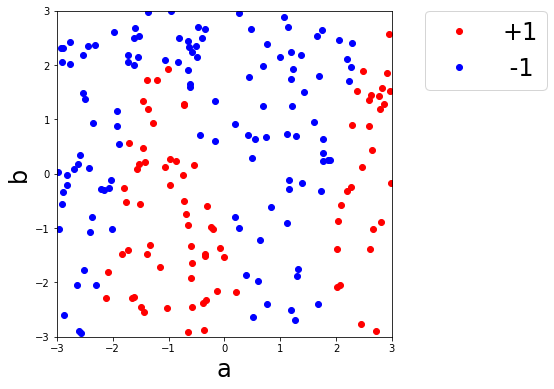

In [10]:
#訓練データのプロット
seq = np.arange(-3, 3, 0.02)
plt.figure(figsize = (6, 6))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot(X[T ==  1,0], X[T ==  1,1], 'ro', label = '+1')
plt.plot(X[T == -1,0], X[T == -1,1], 'bo', label = ' -1')
plt.xlabel("a", fontsize = 24)
plt.ylabel("b", fontsize = 24)
plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=b, fontsize = 24)
plt.show()

In [11]:
u = np.asarray(list(T), dtype = np.float32)

In [12]:
alpha = []

In [13]:
beta = np.zeros(N)
s_list = []
t_list = []

In [14]:
#パラメータ
C = 1
gamma = 1

In [15]:
s_0, t_0 = np.random.choice(np.arange(N),2,replace=False)
s_list.append(s_0)
t_list.append(t_0)

In [16]:
#学習
for ind in range(100):
    s = s_list[ind]
    t = t_list[ind]
    #print(s, t)
    if T[s] == 1 and T[t] == 1:
        Low = np.max([-beta[s], beta[t] - C])
        Max = np.min([C - beta[s], beta[t]])
    elif T[s] == 1 and T[t] == -1:
        Low = np.max([-beta[s], beta[t]])
        Max = np.min([C - beta[s], C + beta[t]])
    elif T[s] == -1 and T[t] == 1:
        Low = np.max([-C - beta[s], beta[t] - C])
        Max = np.min([-beta[s], beta[t]])
    elif T[s] == -1 and T[t] == -1:
        Low = np.max([-C-beta[s], beta[t]])
        Max = np.min([-beta[s], C + beta[t]])
    sum = 0
    for i in range(N):
        sum += beta[i] * (ker(X[i], X[s]))

    thres = (T[s] - T[t] - sum) / (ker(X[s], X[s]) + 2 * ker(X[s], X[t]) + ker(X[t], X[t]))
    
    if Low > thres:
        delta_beta = Low
    elif Max < thres:
        delta_beta = Max
    else:
        delta_beta = thres
    
    beta[s] += delta_beta
    beta[t] -= delta_beta
    
    for i in range(N):
        u[i] -= delta_beta * (ker(X[i], X[s]) - ker(X[i], X[t]))
    
    alpha = beta * T
    
    L1 = []
    L2 = []
    L3 = []
    L4 = []
    L0 = []
    for i in range(N):
        if alpha[i] > 0 and alpha[i] < C:
            L0.append(i)
        elif alpha[i] == 0 and T[i] == 1:
            L1.append(i)
        elif alpha[i] == 0 and T[i] == -1:
            L2.append(i)
        elif alpha[i] == C and T[i] == 1:
            L3.append(i)
        elif alpha[i] == C and T[i] == -1:
            L4.append(i)
    L_up = L0 + L1 + L4
    L_low = L0 + L2 + L3

    s_max_list = []
    t_min_list = []
    for i in L_up:
        s_max_list.append(u[i])
    argmax_s = L_up[np.argmax(np.asarray(s_max_list))]

    for i in L_low:
        t_min_list.append(u[i])
    argmin_t = L_low[np.argmin(np.asarray(t_min_list))]

    s_list.append(argmax_s)
    t_list.append(argmin_t)
alpha = beta * T

In [17]:
#Wの計算を行う関数
def w_f(x):
    W = 0
    for i in range(N):
        W += alpha[i] * T[i] * ker(X[i], x)
    return W

In [18]:
for i in range(N):
    if alpha[i] > 0 and alpha[i] < C:
        b = T[i] - w_f(X[i])

In [19]:
#分類境界の計算
def y_f(x):
    return w_f_ary(x) + b

In [20]:
#分類境界の描画用の計算
n = 100
cont_x = np.linspace(-3, 3, n)
cont_y = np.linspace(-3, 3, n)
 
cont_X, cont_Y = np.meshgrid(cont_x, cont_y)
arg = np.c_[cont_X.ravel(), cont_Y.ravel()]
Z = []
for each_arg in arg:
    each_z = y_f(each_arg)
    Z.append(each_z)

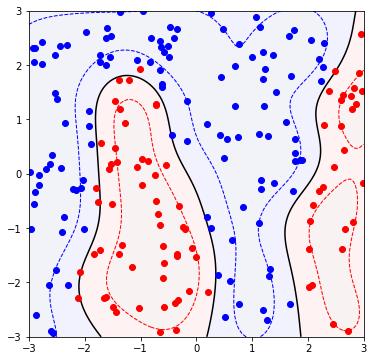

In [21]:
#描画 分類境界以外は学習データそのままプロット
seq = np.arange(-3, 3, 0.02)
plt.figure(figsize = (6, 6))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot(X[T ==  1,0], X[T ==  1,1], 'ro')
plt.plot(X[T == -1,0], X[T == -1,1], 'bo')


plt.contourf(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [-10000,-1, 0, 1,10000], colors = ('darkblue','b', 'r', 'darkred'),alpha = 0.05, linestyles = 'dashed') 
plt.contour(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [-1], colors = ['b'], linestyles = 'dashed', linewidths = (1)) 
plt.contour(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [0], colors = ['k'], linestyles = 'solid') 
plt.contour(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [1], colors = ['r'], linestyles = 'dashed', linewidths = (1))  
plt.show()

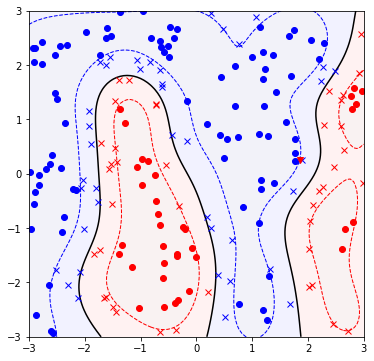

In [22]:
#識別結果のプロット(マージンの内側は✕)
seq = np.arange(-3, 3, 0.02)
plt.figure(figsize = (6, 6))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
for i in range(N):
    if y_f(X[i]) >1:
        plt.plot(X[i][0], X[i][1], 'ro')
    elif y_f(X[i]) < -1:
        plt.plot(X[i][0], X[i][1], 'bo')
    elif y_f(X[i]) > 0 and y_f(X[i]) < 1:
        plt.plot(X[i][0], X[i][1], 'rx')
    elif y_f(X[i]) < 0 and y_f(X[i]) > -1:
        plt.plot(X[i][0], X[i][1], 'bx')
    else:
        plt.plot(X[i][0], X[i][1], 'rv')

plt.contourf(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [-10000,-1, 0, 1,10000], colors = ('darkblue','b', 'r', 'darkred'),alpha = 0.05, linestyles = 'dashed') 
plt.contour(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [-1], colors = ['b'], linestyles = 'dashed', linewidths = (1)) 
plt.contour(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [0], colors = ['k'], linestyles = 'solid') 
plt.contour(cont_x, cont_y, np.asarray(Z).reshape(cont_X.shape), levels = [1], colors = ['r'], linestyles = 'dashed', linewidths = (1)) 
plt.show()

In [23]:
#正解数・誤答数の計算
correct_count = 0
wrong_count = 0
zero_count = 0
for i in range(N):
    if y_f(X[i]) * T[i] > 0:
        correct_count += 1
    elif y_f(X[i]) * T[i] < 0:
        wrong_count += 1
    else:
        zero_count += 1
print(correct_count, wrong_count, zero_count)

194 6 0


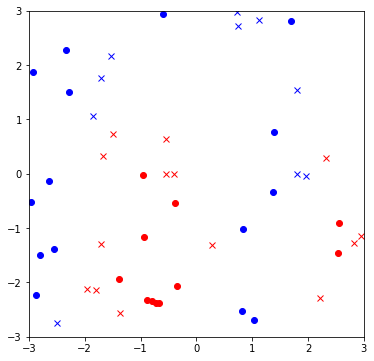

In [24]:
#評価データの識別
test_num = 50
seq = np.arange(-3, 3, 0.02)
plt.figure(figsize = (6, 6))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
#for i in range(400):
x = np.random.rand(test_num, 2) * 6 - 3
for i in range(test_num):
    if y_f(x[i]) >1:
        plt.plot(x[i][0], x[i][1], 'ro')
    elif y_f(x[i]) < -1:
        plt.plot(x[i][0], x[i][1], 'bo')
    elif y_f(x[i]) > 0 and y_f(x[i]) < 1:
        plt.plot(x[i][0], x[i][1], 'rx')
    elif y_f(x[i]) < 0 and y_f(x[i]) > -1:
        plt.plot(x[i][0], x[i][1], 'bx')
    else:
        plt.plot(x[i][0], x[i][1], 'rv')
plt.show()

In [25]:
#評価データの正解数・誤答数の計算
cor = 0
wro = 0
zero = 0
for i in range(test_num):
    if f(x[i][0], x[i][1]) * y_f(x[i]) > 0:
        cor += 1
    elif f(x[i][0], x[i][1]) * y_f(x[i]) < 0:
        wro += 1
    else:
        zero += 1
print(cor, wro, zero)

49 1 0


In [26]:
#f値・正解率の計算
tp = 0
tn = 0
fp = 0
fn = 0
print(C, gamma)
for i in range(test_num):
    if f(x[i][0], x[i][1]) > 0 and  y_f(x[i]) > 0:
        tp += 1
    elif f(x[i][0], x[i][1]) < 0 and  y_f(x[i]) > 0:
        fp += 1
    elif f(x[i][0], x[i][1]) > 0 and  y_f(x[i]) < 0:
        tn += 1
    elif f(x[i][0], x[i][1]) < 0 and  y_f(x[i]) < 0:
        fn += 1
print(tp, fp, tn, fn)
pr = float(tp)/(tp + fp)
re = float(tp) / (tp + fn)
f_measure = float(2 * pr * re) / (pr + re)
acc = float(tp + fn ) / (tp + fn + fp + tn)
print(f_measure, acc)

1 1
24 1 0 25
0.6486486486486486 0.98
